### Để chạy file notebook. Để file này vào chung với thư mục datasets -> chọn thời gian chạy-> chạy tất cả. Có thể đổi các tập huấn luyện từ u1.base thành u2-u5.base và u1. test thành u2.test-u5.test để kiểm tra độ đo của mô hình . Notebook được thực hiện và chạy trên môi trường google colab.

## 1. Import Module

In [29]:
import numpy as np
import pandas as pd
import networkx as nx
import itertools
import collections
import itertools
import math
import scipy
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Input, Dense
from keras.models import Model
import tensorflow as tf
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.cluster import KMeans
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib as plt

## 2. Prepare data

In [30]:
# processing and lod data
def load_data(dataPath):
    df = pd.read_csv(dataPath + 'u1.base',
                     sep='\\t',
                     engine='python',
                     names=['UID', 'MID', 'rate', 'time'])
    df_user = pd.read_csv(dataPath + 'u.user',
                          sep='\\|',
                          engine='python',
                          names=['UID', 'age', 'gender', 'job', 'zip'])

    df_user = convert_categorical(df_user, 'job')
    df_user = convert_categorical(df_user, 'gender')
    df_user['bin'] = pd.cut(df_user['age'], [0, 10, 20, 30, 40, 50, 100],
                            labels=['1', '2', '3', '4', '5', '6'])
    df_user['age'] = df_user['bin']

    df_user = df_user.drop(columns='bin')
    df_user = convert_categorical(df_user, 'age')
    df_user = df_user.drop(columns='zip')
    return df, df_user

In [31]:
# OneHotEncoder label
def convert_categorical(df_X, _X):
    values = np.array(df_X[_X])
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    df_X = df_X.drop(columns=_X)
    for j in range(integer_encoded.max() + 1):
        df_X.insert(loc=j + 1,
                    column=str(_X) + str(j + 1),
                    value=onehot_encoded[:, j])
    return df_X


## 3. Extract features

In [32]:
# Build graph
def train_model(df, df_user):
    alpha_coefs = [0.01]

    for alpha_coef in alpha_coefs:
        pairs = []
        grouped = df.groupby(['MID', 'rate'])

        for key, group in grouped:
            pairs.extend(list(itertools.combinations(group['UID'], 2)))

        counter = Counter(pairs)
        alpha = alpha_coef * 1682  # param*i_no
        edge_list = map(
            list,
            Counter(el for el in counter.elements()
                    if counter[el] >= alpha).keys())
        G = nx.Graph()

        for el in edge_list:
            G.add_edge(el[0], el[1], weight=1)

        #plt.figure(figsize=(6, 6))
        #plt.figure(figsize = (15,10))
        #pos = nx.kamada_kawai_layout(G)
        #node_options = {"node_color": "black", "node_size" :30}
        #edge_options = {"width":.50, "alpha" : .5 , "edge_color" : "black"}
        #nx.draw_networkx_nodes(G, pos, **node_options)
        #nx.draw_networkx_edges(G, pos, **edge_options)
        #plt.show()\\u2.test

        pr = nx.pagerank(G.to_directed())
        df_user['PR'] = df_user['UID'].map(pr)
        df_user['PR'] /= float(df_user['PR'].max())
        dc = nx.degree_centrality(G)
        df_user['CD'] = df_user['UID'].map(dc)
        df_user['CD'] /= float(df_user['CD'].max())
        cc = nx.closeness_centrality(G)
        df_user['CC'] = df_user['UID'].map(cc)
        df_user['CC'] /= float(df_user['CC'].max())
        bc = nx.betweenness_centrality(G)
        df_user['CB'] = df_user['UID'].map(bc)
        df_user['CB'] /= float(df_user['CB'].max())
        lc = nx.load_centrality(G)
        df_user['LC'] = df_user['UID'].map(lc)
        df_user['LC'] /= float(df_user['LC'].max())
        nd = nx.average_neighbor_degree(G, weight='weight')
        df_user['AND'] = df_user['UID'].map(nd)
        df_user['AND'] /= float(df_user['AND'].max())
        X_train = df_user.loc[:, df_user.columns[1:]]
        X_train.fillna(0, inplace=True)
        X_train.to_pickle("data100k/x_train_alpha(" + str(alpha_coef) +
                          ").pkl")

## 4. Load Data Users(df_user), Ratings(df)




In [33]:
dataPath = 'datasets/ml-100k/'
df, df_user = load_data(dataPath)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [34]:
df

,UID,MID,rate,time
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
79995,943,1067,2,875501756
79996,943,1074,4,888640250
79997,943,1188,3,888640250
79998,943,1228,3,888640275


In [35]:
df_user
#has been processed by OnehotEncoder

,UID,age1,age2,age3,age4,age5,age6,gender1,gender2,job1,...,job12,job13,job14,job15,job16,job17,job18,job19,job20,job21
0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,939,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
939,940,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,941,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
941,942,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5. Buid Graph and Extracfeature

In [36]:
train_model(df, df_user)
dataPath = 'data100k/'
X_train = pd.read_pickle(dataPath + 'x_train_alpha(0.01).pkl').values.astype(float)
X_train.shape

(943, 35)

## 6. Train Autoencoder Model

In [37]:
# Define autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoded_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 16), nn.ReLU(),
                                     nn.Linear(16, encoded_dim))
        self.decoder = nn.Sequential(nn.Linear(encoded_dim, 16), nn.ReLU(),
                                     nn.Linear(16, input_dim), nn.ReLU())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    def compute_l1_loss(self, w):
      return torch.abs(w).sum()

    def compute_l2_loss(self, w):
      return torch.square(w).sum()

In [38]:
# Train autoencoder
input_dim = X_train.shape[1]
encoded_dim = 4
autoencoder = Autoencoder(input_dim, encoded_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
num_epochs = 100
noise_factor= 0.3
num_workers = 0
traindata = torch.FloatTensor(X_train)
# prepare data loaders
train_loader = torch.utils.data.DataLoader(traindata, batch_size=10, num_workers=10)
k= []
for epoch in range(num_epochs):
  for data in train_loader:
    inputs = data
    noisy_inputs = inputs + noise_factor * torch.randn(*inputs.shape)
    # Clip the images to be between 0 and 1
    #noisy_inputs = np.clip(noisy_inputs, 0., 1.)
    encoded, decoded = autoencoder(noisy_inputs)
    loss = criterion(decoded, inputs)
    l1_weight = 0.001
    l2_weight = 0.001
    parameters = []
    for parameter in autoencoder.parameters():
        parameters.append(parameter.view(-1))
    l1 = l1_weight * autoencoder.compute_l1_loss(torch.cat(parameters))
    l2 = l2_weight * autoencoder.compute_l2_loss(torch.cat(parameters))

    loss += l1
    loss += l2
    optimizer.zero_grad()
    loss.backward()


    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs,
                                                  loss.item()))
  k.append(loss)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [10/100], Loss: 0.0708
Epoch [10/100], Loss: 0.0769
Epoch [10/100], Loss: 0.0743
Epoch [10/100], Loss: 0.0736
Epoch [10/100], Loss: 0.0697
Epoch [10/100], Loss: 0.0695
Epoch [10/100], Loss: 0.0700
Epoch [10/100], Loss: 0.0709
Epoch [10/100], Loss: 0.0733
Epoch [10/100], Loss: 0.0756
Epoch [10/100], Loss: 0.0640
Epoch [10/100], Loss: 0.0695
Epoch [10/100], Loss: 0.0785
Epoch [10/100], Loss: 0.0691
Epoch [10/100], Loss: 0.0791
Epoch [10/100], Loss: 0.0704
Epoch [10/100], Loss: 0.0741
Epoch [10/100], Loss: 0.0749
Epoch [10/100], Loss: 0.0699
Epoch [10/100], Loss: 0.0662
Epoch [10/100], Loss: 0.0776
Epoch [10/100], Loss: 0.0696
Epoch [10/100], Loss: 0.0753
Epoch [10/100], Loss: 0.0744
Epoch [10/100], Loss: 0.0609
Epoch [10/100], Loss: 0.0736
Epoch [10/100], Loss: 0.0792
Epoch [10/100], Loss: 0.0792
Epoch [10/100], Loss: 0.0639
Epoch [10/100], Loss: 0.0785
Epoch [10/100], Loss: 0.0685
Epoch [10/100], Loss: 0.0739
Epoch [10/100], Loss: 0.0722
Epoch [10/100], Loss: 0.0705
Epoch [10/100]

### MSE of Autoencoder

In [39]:
#print("MSE of Autoencoder",np.mean(k))

In [40]:
# encoded_features, _ = autoencoder(torch.from_numpy(X_train).float())
# encoded_features = encoded_features.detach().numpy()
# encoded_features

### Save features

In [41]:
PATH = 'models/autoencoder.pt'
torch.save(autoencoder.encoder, PATH)
# PATH_BEST = 'models/autoencoder_best.pt'
# encoder = torch.load('models/autoencoder_best.pt')
encoder = torch.load('models/autoencoder.pt')
with torch.no_grad():
    encoded_features, _ = autoencoder(torch.from_numpy(X_train).float())
encoded_features = encoded_features.detach().numpy()
encoded_features.shape

(943, 4)

In [42]:
# Save encoded features to file
encoded_features_df = pd.DataFrame(encoded_features)
encoded_features_df.to_pickle('data/encoded_features/encoded_features.pkl')


## 7. KMeans clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

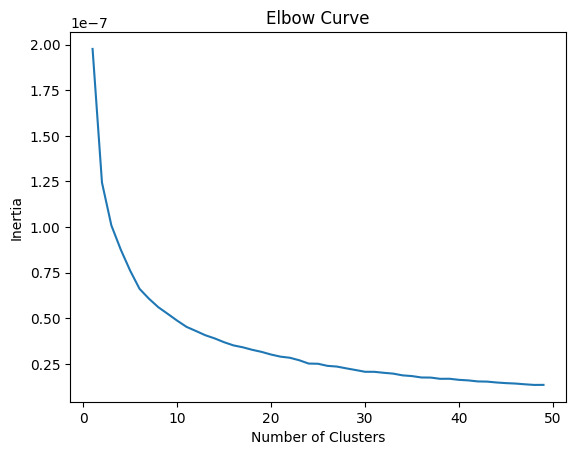

In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine the number of clusters
elbow = []
for i in range(1, 50):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(encoded_features)
    elbow.append(kmeans.inertia_)

# Plot elbow curve to determine the optimal number of clusters
plt.plot(range(1, 50), elbow)
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [44]:
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10).fit(encoded_features)
cluster_labels = kmeans.labels_

In [45]:
#Create user-cluster mattrix
Cluster = ['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6']
df1 = pd.DataFrame(np.zeros((943,7)), columns=Cluster)
df1.index = df1.index + 1
UID = 1
for i in cluster_labels:
  df1.loc[UID][i] = 1
  UID = UID + 1
df1

,cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,1.0,0.0
940,1.0,0.0,0.0,0.0,0.0,0.0,0.0
941,0.0,0.0,0.0,0.0,1.0,0.0,0.0
942,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
dataPath = 'datasets/ml-100k/'
df_read = pd.read_csv(dataPath+'u1.base', sep='\\t', engine='python', names=['UID', 'MID', 'rate', 'time'])
df_read = df_read.drop(['time'], axis = 1)
df_read = df_read.pivot(index = 'UID', columns = 'MID', values = 'rate')
df = pd.DataFrame(0, columns=list(range(1,1683)), index=list(range(1,944)))
df = df.combine(df_read, np.maximum)

In [47]:
df2 = pd.DataFrame(index = Cluster, columns=list(range(1,1683)))
df2

,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
cluster0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cluster1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cluster2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cluster3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cluster4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cluster5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cluster6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
def find_similar_movie(cluster_rate, mid, df_item):
    similar_Movies = []
    genres = df_item[mid-1]
    for Movies in cluster_rate.index:
        comp_genres = df_item[Movies - 1]
        if np.array_equal(genres, comp_genres) and Movies != mid:
            similar_Movies.append(Movies)
    return similar_Movies

In [49]:
def check_user_exist(Movies, users, df):
  if df.loc[users][Movies].isnull().all().all() == False:
    return True
  else:
    return False

## 9. Predict Cluster's rating movies in df2

In [50]:
dataPath = 'datasets/ml-100k/'
df_item = pd.read_csv(dataPath + 'u.item', sep='\\|', engine='python',
                      names=['MID', 'title', 'rdate', 'vdate', 'URL', 'unknown', 'Action', 'Adventure', 'Animation',
                              'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
                              'Western'], encoding='latin-1')
df_item = df_item[df_item.columns[5:]]
df_item = np.array(df_item)

for Movie in df2.columns:
  for cluster in Cluster:
    user = df1.index[df1[cluster] == 1]
    if df.loc[user][Movie].isnull().all().all() == False:
        df2.loc[cluster][Movie] = np.nanmean(df.loc[user][Movie])
        # df2.loc[cluster][Movie] = df.loc[user][Movie].mode()
        continue
    # else :
    #     df2.loc[cluster][Movie] = np.nanmean(df.loc[df.index][Movie])
    S_M = find_similar_movie(df2.loc[cluster], Movie, df_item)
    if check_user_exist(S_M, user, df) == True:
        df2.loc[cluster][Movie] = np.nanmean(df.loc[user][S_M])
    else:
        df2.loc[cluster][Movie] = np.nanmean(df.loc[user])

In [51]:
df2

,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
cluster0,3.759494,3.185185,2.666667,3.404255,3.235294,3.571429,3.772152,3.978261,3.640625,3.5,...,3.0,3.681209,3.681209,3.681209,3.681209,3.681209,3.928571,3.606,3.229073,3.681209
cluster1,3.891304,3.285714,2.625,3.4,3.454545,3.0,3.676471,4.125,3.833333,4.4,...,3.404332,3.550041,3.550041,3.550041,3.550041,3.550041,3.5,3.672655,3.31058,3.550041
cluster2,3.893617,3.0,3.416667,3.833333,3.3,3.666667,3.918919,3.941176,4.357143,3.777778,...,3.398417,3.788618,3.788618,3.788618,3.788618,3.788618,3.52381,3.665988,3.380412,3.0
cluster3,4.0,3.2,2.833333,3.529412,3.285714,4.5,3.72093,3.8,3.7,4.2,...,3.463612,4.0,3.762943,3.762943,3.762943,3.762943,3.538462,3.625743,3.291099,3.762943
cluster4,3.702128,3.384615,3.5,3.8125,3.090909,3.666667,3.8,4.176471,3.772727,3.857143,...,3.481481,3.667456,3.0,2.0,3.667456,1.0,3.0,2.0,3.123256,3.667456
cluster5,3.983333,3.125,2.363636,3.681818,3.444444,2.0,3.756098,4.074074,3.636364,4.0,...,3.436275,3.643001,3.643001,3.643001,3.0,3.643001,3.181818,3.666667,3.0,3.643001
cluster6,4.066667,3.166667,3.833333,3.24,3.5,2.5,4.0,3.882353,3.92,3.571429,...,3.379085,3.626471,3.626471,3.626471,3.626471,3.626471,3.5,3.580556,3.245742,3.626471


## 10. Predict User's rating for all movies

In [52]:
# np.dot(df1, df2)
prediction = df1.dot(df2)
#df2.dot(df1)
prediction

,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
1,4.066667,3.166667,3.833333,3.24,3.5,2.5,4.0,3.882353,3.92,3.571429,...,3.379085,3.626471,3.626471,3.626471,3.626471,3.626471,3.5,3.580556,3.245742,3.626471
2,3.893617,3.0,3.416667,3.833333,3.3,3.666667,3.918919,3.941176,4.357143,3.777778,...,3.398417,3.788618,3.788618,3.788618,3.788618,3.788618,3.52381,3.665988,3.380412,3.0
3,3.983333,3.125,2.363636,3.681818,3.444444,2.0,3.756098,4.074074,3.636364,4.0,...,3.436275,3.643001,3.643001,3.643001,3.0,3.643001,3.181818,3.666667,3.0,3.643001
4,4.066667,3.166667,3.833333,3.24,3.5,2.5,4.0,3.882353,3.92,3.571429,...,3.379085,3.626471,3.626471,3.626471,3.626471,3.626471,3.5,3.580556,3.245742,3.626471
5,3.759494,3.185185,2.666667,3.404255,3.235294,3.571429,3.772152,3.978261,3.640625,3.5,...,3.0,3.681209,3.681209,3.681209,3.681209,3.681209,3.928571,3.606,3.229073,3.681209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,3.983333,3.125,2.363636,3.681818,3.444444,2.0,3.756098,4.074074,3.636364,4.0,...,3.436275,3.643001,3.643001,3.643001,3.0,3.643001,3.181818,3.666667,3.0,3.643001
940,3.759494,3.185185,2.666667,3.404255,3.235294,3.571429,3.772152,3.978261,3.640625,3.5,...,3.0,3.681209,3.681209,3.681209,3.681209,3.681209,3.928571,3.606,3.229073,3.681209
941,3.702128,3.384615,3.5,3.8125,3.090909,3.666667,3.8,4.176471,3.772727,3.857143,...,3.481481,3.667456,3.0,2.0,3.667456,1.0,3.0,2.0,3.123256,3.667456
942,3.759494,3.185185,2.666667,3.404255,3.235294,3.571429,3.772152,3.978261,3.640625,3.5,...,3.0,3.681209,3.681209,3.681209,3.681209,3.681209,3.928571,3.606,3.229073,3.681209


## 11. Root Mean Square Error

In [53]:
dataPath = 'datasets/ml-100k/'
df_test = pd.read_csv(dataPath+'u1.test', sep='\\t', engine='python', names=['UID', 'MID', 'rate', 'time'])
df_test = df_test.drop(['time'], axis = 1)
df_test = df_test.pivot(index = 'UID', columns = 'MID', values = 'rate')
df_test

MID,1,2,3,4,5,6,7,8,9,10,...,1555,1557,1561,1562,1563,1565,1578,1582,1586,1591
UID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
RMSE = np.sqrt(np.nanmean(np.square(df_test - prediction)))
print("RMSE of Hybrid approach for movies recommendation based on Graph and Autoencoder:",RMSE)

RMSE of Hybrid approach for movies recommendation based on Graph and Autoencoder: 1.083535444196354


## 12.Precision and Recall

In [63]:
#Define Precision and Recall
def Precision_Recall(user, df_True, df_Predict, top_N):
  TP = 0
  FP = 0
  FN = 0

  top_n_recommendations = prediction.loc[user].sort_values(ascending=False).head(top_N)
  if len(top_n_recommendations) == 0:
    return(1, 1)
  for movie in df_True.columns :
    if df_True.loc[user][movie] >= 4:
      if movie in top_n_recommendations.index :
        TP += 1
      else:
        FN += 1
    elif df_True.loc[user][movie] < 4:
      if movie in top_n_recommendations.index :
        FP += 1
    else:
      continue
  if TP == 0:
    return (0, 0)
  precision = TP/(TP + FP)
  recall = TP/(TP + FN)
  return(precision, recall)

In [64]:
predictions = prediction - df_test + df_test
Precision = []
Recall = []

for user in df_test.index:
  pre, re = Precision_Recall(user, df_test, predictions, 20)
  Precision.append(pre)
  Recall.append(re)
print("Precision", np.mean(Precision))
print("Recall:", np.mean(Recall))

Precision 0.6682834154924848
Recall: 0.7187738507510105


## 13. In ra những bộ phim gợi ý cho người xem

In [65]:
UID = 200
top_N = 20
MovieRecommend = prediction.loc[940].sort_values(ascending=False).head(top_N).index.values
# load the u.item file
df_item = pd.read_csv(dataPath + 'u.item', sep='\\|', engine='python',
                      names=['MID', 'title', 'rdate', 'vdate', 'URL', 'unknown', 'Action', 'Adventure', 'Animation',
                              'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
                              'Western'], encoding='latin-1')
for mid in MovieRecommend:
    movie_name = df_item.loc[df_item['MID'] == mid]['title'].values[0]
    print(movie_name)


Toy Story (1995)
GoldenEye (1995)
Four Rooms (1995)
Get Shorty (1995)
Copycat (1995)
Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
Twelve Monkeys (1995)
Babe (1995)
Dead Man Walking (1995)
Richard III (1995)
Seven (Se7en) (1995)
Usual Suspects, The (1995)
Mighty Aphrodite (1995)
Postino, Il (1994)
Mr. Holland's Opus (1995)
French Twist (Gazon maudit) (1995)
From Dusk Till Dawn (1996)
White Balloon, The (1995)
Antonia's Line (1995)
Angels and Insects (1995)
